In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

170500096it [00:06, 28038216.46it/s]                               


Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10
for i in range(5000):
    images, labels = dataiter.next()
    for j in range(batch_size):
        if(classes[labels[j]] in background_classes):
            img = images[j].tolist()
            background_data.append(img)
            background_label.append(labels[j])
        else:
            img = images[j].tolist()
            foreground_data.append(img)
            foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
# print(foreground_data.size())
# print(background_data.size())
# torch.save(foreground_data,'foreground_data.pt')
# torch.save(background_data,'background_data.pt')
# torch.save(foreground_label,'foreground_label.pt')
# torch.save(background_label,'background_label.pt')
# torch.load()

In [0]:
# torch.load('foreground_data.pt')
# # print(foreground_data.size())
# # print(background_data.size())

In [0]:

# foreground_data = torch.load('foreground_data.pt')
# background_data = torch.load('background_data.pt')
# foreground_label = torch.load('foreground_label.pt')
# background_label = torch.load('background_label.pt')


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img#.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

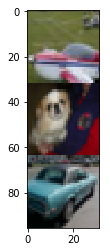

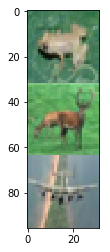

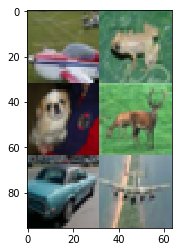

torch.Size([3, 96, 32])


In [52]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
      if i != fg:
          image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
          j+=1
      else: 
          image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
          label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx =[]                   #list of indexes at which foreground image is present in a mosaic image                
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)



In [0]:
#imshow(mosaic_list_of_images[0][4])
# print(mosaic_list_of_images[0])
# print(classes[mosaic_label[13]+7]) # add 7 as we had subtracted 7 while saving
# print(fore_idx[13])
# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""

    def __init__(self, mosaic_list_of_images, mosaic_label):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mosaic = mosaic_list_of_images
        self.label = mosaic_label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
      return self.mosaic[idx] , self.label[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images,mosaic_label)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
    def __init__(self):
        super(Module1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
# net = Module1()
# print(net.parameters)

In [0]:
# class Module2(nn.Module):
#     def __init__(self):
#         super(Module2, self).__init__()
#         self.module1 = Module1().double()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
#         self.fc4 = nn.Linear(10,3)

#     def forward(self,z):  #z batch of list of 9 images
#         y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
#         x = torch.zeros([batch,9],dtype=torch.float64)
        
#         for i in range(9):
#             x[:,i] = self.module1.forward(z[:,i])[:,0]
            
# #         print(x[0])
#         x = F.softmax(x,dim=1)
# #         s = torch.sum(x[0])
# #         print(x[0])
# #         print("sum",s)
        
#         x1 = x[:,0]
# #         print(x1.size())
#         torch.mul(x1[:,None,None,None],z[:,0])
#         for i in range(9):
            
#           x1 = x[:,i]
          
#           y = y + torch.mul(x1[:,None,None,None],z[:,i])


         
# #         print(y[0].detach().numpy()size())

# #  *******************       img = z[0][0]
#         imshow(y[0].detach().numpy())
#         img = y[0].detach().numpy()
#         img = img / 2 + 0.5     # unnormalize
#         npimg = img
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))
#         plt.show()
# #*************************************************
        
#         y = self.pool(F.relu(self.conv1(y)))
#         y = self.pool(F.relu(self.conv2(y)))
#         y = y.view(-1, 16 * 5 * 5)
        
#         y = F.relu(self.fc1(y))
#         y = F.relu(self.fc2(y))
#         y = F.relu(self.fc3(y))
#         y = self.fc4(y)
#         return y
    
# fore_net = Module2().double()
# # print(fore_net.parameters)

In [70]:
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
# for epoch in range(50):  # loop over the dataset multiple times

#     running_loss = 0.0
#     cnt=0
    
#     iteration = desired_num // batch
#     for i, data in  enumerate(train_loader):
    
#         inputs , labels = data
        
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         #******************************** check image before passing*****************
# #         img = inputs[0][0]
# #         img = img / 2 + 0.5     # unnormalize
# #         npimg = img
# #         plt.imshow(np.transpose(npimg, (1, 2, 0)))
# #         plt.show()
# # 
#         outputs = fore_net(inputs)
# #         print(outputs.shape,labels.shape , torch.argmax(outputs))
#         loss = criterion(outputs, labels) 
#         loss.backward()
#         optimizer.step()
# #         print(loss.item())
#         # print statistics
#         running_loss += loss.item()
#         if cnt % 40 == 39:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 40))
#             running_loss = 0.0
#         cnt=cnt+1
# #     print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt , running_loss/cnt))
# #     print(running_loss)
# print('Finished Training')

[1,    40] loss: 1.104
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.099
[2,    80] loss: 1.099
[2,   120] loss: 1.098
[3,    40] loss: 1.098
[3,    80] loss: 1.098
[3,   120] loss: 1.098
[4,    40] loss: 1.098
[4,    80] loss: 1.098
[4,   120] loss: 1.097
[5,    40] loss: 1.097
[5,    80] loss: 1.097
[5,   120] loss: 1.096
[6,    40] loss: 1.095
[6,    80] loss: 1.093
[6,   120] loss: 1.091
[7,    40] loss: 1.086
[7,    80] loss: 1.086
[7,   120] loss: 1.084
[8,    40] loss: 1.081
[8,    80] loss: 1.080
[8,   120] loss: 1.078
[9,    40] loss: 1.079
[9,    80] loss: 1.076
[9,   120] loss: 1.077
[10,    40] loss: 1.078
[10,    80] loss: 1.074
[10,   120] loss: 1.072
[11,    40] loss: 1.072
[11,    80] loss: 1.070
[11,   120] loss: 1.073
[12,    40] loss: 1.069
[12,    80] loss: 1.068
[12,   120] loss: 1.067
[13,    40] loss: 1.067
[13,    80] loss: 1.059
[13,   120] loss: 1.065
[14,    40] loss: 1.064
[14,    80] loss: 1.059
[14,   120] loss: 1.060
[15,    40] loss: 1

In [0]:
class Module2(nn.Module):
    def __init__(self):
        super(Module2, self).__init__()
        self.module1 = Module1().double()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)

    def forward(self,z):  #z batch of list of 9 images
        y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
        x = torch.zeros([batch,9],dtype=torch.float64)
        
        for i in range(9):
            x[:,i] = self.module1.forward(z[:,i])[:,0]
            
#         print(x[0])
        x = F.softmax(x,dim=1)
#         s = torch.sum(x[0])
#         print(x[0])
#         print("sum",s)
        
        x1 = x[:,0]
#         print(x1.size())
        torch.mul(x1[:,None,None,None],z[:,0])
        for i in range(9):
            
          x1 = x[:,i]
          
          y = y + torch.mul(x1[:,None,None,None],z[:,i])


         
#         print(y[0].detach().numpy()size())

#  *******************       
#         imshow(y[0].detach().numpy())
        img = y[2].detach().numpy()
        img = img / 2 + 0.5     # unnormalize
        npimg = img
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
#*************************************************
        
        y = self.pool(F.relu(self.conv1(y)))
        y = self.pool(F.relu(self.conv2(y)))
        y = y.view(-1, 16 * 5 * 5)
        
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = F.relu(self.fc3(y))
        y = self.fc4(y)
        return y
      
fore_net = Module2().double()

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

4


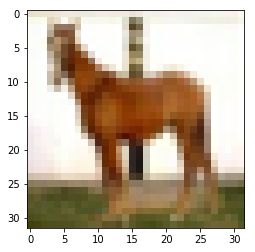

horse


In [132]:
print(fore_idx[0])
imshow(test_images[0][fore_idx[0]])
print(classes[test_label[0]+7])

In [0]:
class TestDataset(Dataset):
    """MosaicDataset dataset."""

    def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mosaic = mosaic_list_of_images
        self.label = mosaic_label
        self.fore_idx = fore_idx

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
      return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]    
test_data = TestDataset(test_images,test_label,fore_idx)
test_loader = DataLoader( test_data,batch_size= batch,shuffle=True)

true image ========== class is  truck


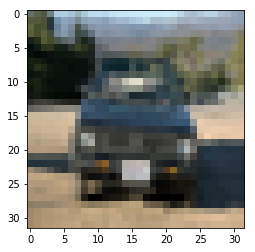

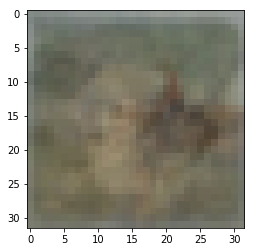

true image ========== class is  horse


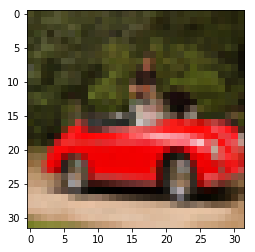

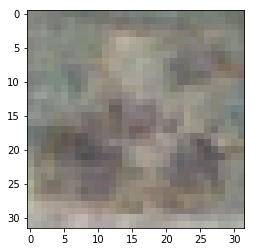

true image ========== class is  horse


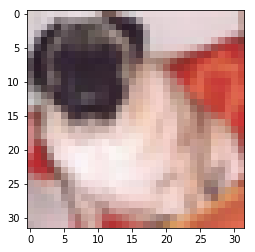

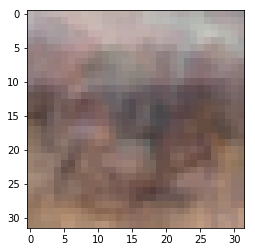

true image ========== class is  ship


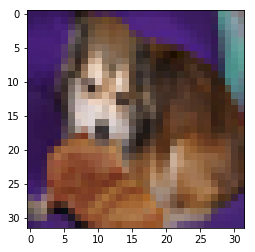

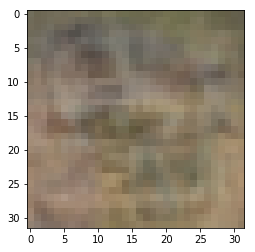

true image ========== class is  ship


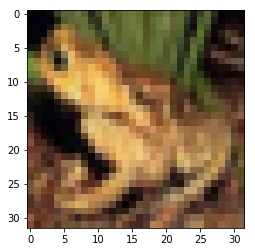

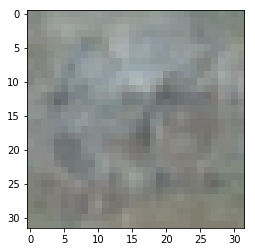

true image ========== class is  truck


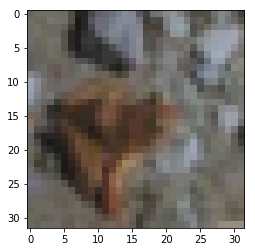

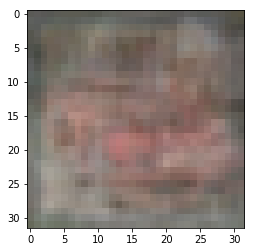

true image ========== class is  ship


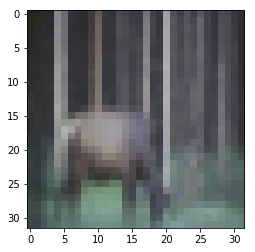

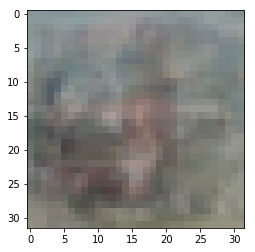

true image ========== class is  truck


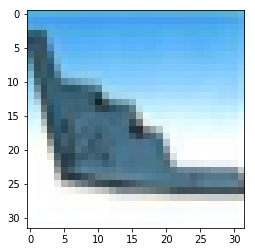

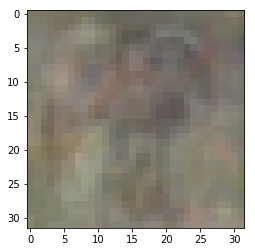

true image ========== class is  ship


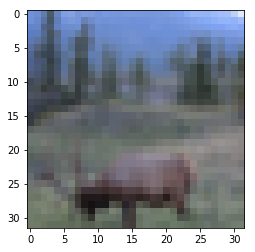

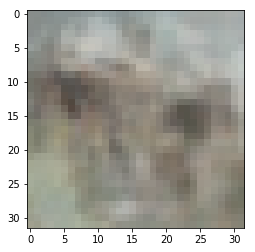

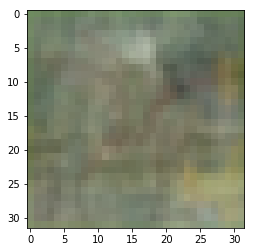

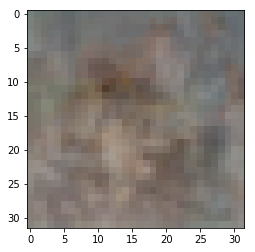

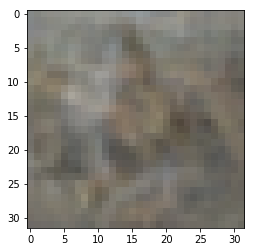

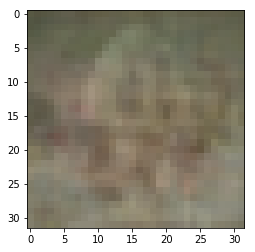

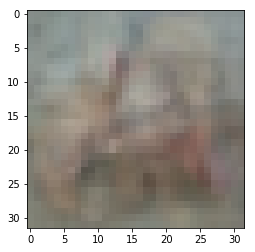

KeyboardInterrupt: ignored

In [157]:
correct = 0
total = 0
count = 0
with torch.no_grad():
    for data in test_loader:
        images, labels, f_idx = data
        #***************************
        if(count<9):
          print("true image","="*10,"class is ", classes[labels[count]+7])
          img = inputs[count][f_idx[count]]
          img = img / 2 + 0.5     # unnormalize
          npimg = img
          plt.imshow(np.transpose(npimg, (1, 2, 0)))
          plt.show()
          count=count+1
        #************************************
        outputs = fore_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [83]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = fore_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 91 %


In [0]:
obj = test_loader

0
truck


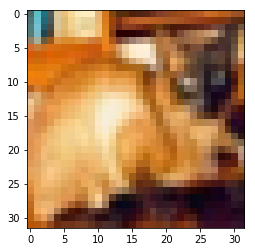

In [156]:
c=54
print(obj.dataset.fore_idx[c])
print(classes[obj.dataset.label[c]+7])
imshow(obj.dataset.mosaic[c][4])